## Notebook : Active learning method comparison and implementation

### Outline

* [Initialization](#init)
* [Feature extraction and prediction](#feat-extract)
* [Core set selection with DBSCAN Clustering](#select-dbscan)
* [Core set selection with KMeans Clustering](#select-kmean)
* [Uncertainty Sampling](#u-sampling)



### Initialization
<a id="init"></a>
Import modules and set data directory


In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import shutil
import pickle
from tqdm import tqdm
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from matplotlib.patches import Circle
import pandas as pd

# Custom imports
from utils.preprocessing import preprocess_image
from utils.architectures import EffNetB0, CustomUnet
from utils.DCoM import DCoM

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


c:\Users\Alexandre Bonin\Documents\Stage\active-learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mode = 'segmentation'
data_path = r'C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024'
model_path = r'C:\Users\Alexandre Bonin\Documents\Stage\Code segmentation (Leo)\Models\VL_2024+basemodelproxicam.pt'
model = CustomUnet(encoder_name="resnet50",
            encoder_weights="imagenet",
            classes = 2,
            activation=None,
            encoder_depth=5,
            decoder_channels=[256, 128, 64, 32, 16],
            extract_features=True
            ).to(device)

# mode = 'classification'
# data_path = r'C:\Users\Alexandre Bonin\Documents\Stage\datasets\ProspectFD\test'
# model_path = r'models\Run_2024-10-16_14-15-17.pth'
# model = EffNetB0(num_classes=2, model_path = model_path, extract_features = True).to(device)

output_dir = os.path.join(data_path + '/DCoM')


if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

model.eval();


## Feature extraction and prediction 
<a id="feat-extract"></a>
Extract features from images and make prediction

In [28]:
# Initialize lists to store features and labels
features = []
pseudo_labels = []

features_file = os.path.join(output_dir, 'features.pkl')
pred_file = os.path.join(output_dir, 'pred_df.pkl')
pseudo_labels_file = os.path.join(output_dir, 'pseudo_labels.pkl')

# Iterate over the images in the directory
img_list = [fname for fname in os.listdir(data_path) if fname.endswith(('jpg', 'jpeg', 'png'))]
img_list = [img_name for img_name in img_list[:]]

# Check if the pickle files exist
if os.path.exists(features_file) :
    with open(features_file, 'rb') as f:
        features = pickle.load(f)

if os.path.exists(pseudo_labels_file):
    with open(pseudo_labels_file, 'rb') as f:
        pseudo_labels = pickle.load(f)

if os.path.exists(pred_file): #Make sure it is the right file
    print("Loading features and predictions from pickle files...")
    # Load the variables from the pickle files
    with open(pred_file, 'rb') as f:
        pred_df = pickle.load(f)
       
else :
    # Initialize a DataFrame to store file paths and prediction probabilities
    pred_df = pd.DataFrame(columns=['img_name', 'pred', 'delta', 'true_label'])
    pred_df['img_name'] = img_list

for img_name in tqdm(img_list):
    file_path = os.path.join(data_path, img_name )

    if os.path.isfile(file_path):
        try:
            # Open and preprocess the image
            img_tensor = preprocess_image(file_path)
            # Make predictions and extract features
            with torch.no_grad():
                pred, feature = model(img_tensor)  # Add batch dimension

            features.append(feature.squeeze(0).cpu().numpy())  # Remove batch dimension and convert to numpy
            pred = torch.softmax(pred, dim=1)

            if mode == 'segmentation' :
              # Get the maximum probabilities and predicted classes
                max_probs, binary = torch.max(pred, dim=1)
                avg_confidence = max_probs.mean().item()

                # Convert tensors to NumPy arrays
                max_probs = max_probs.cpu().numpy()
                binary = binary.cpu().numpy()

                # Calculate the ratio of positive pixels (assuming class 1 is positive)
                positive_pixels = (binary == 1).sum()
                total_pixels = binary.size
                positive_proportion = positive_pixels / total_pixels

                # Store the positive proportion
                pseudo_labels.append(positive_proportion)
                pred_df.loc[pred_df['img_name'] == img_name, 'pred'] = avg_confidence

            elif mode == 'classification' :
                pseudo_labels.append(pred.argmax(dim=1).item())  # Get the predicted class label
                # Create a DataFrame for the current prediction
                pred_df.loc[pred_df['img_name'] == img_name, 'pred'] = pred.max().cpu().numpy()
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            # Delete the row with the corresponding file name
            pred_df = pred_df[pred_df['img_name'] != img_name]


# Convert features and labels to numpy arrays
features = np.array(features)
pseudo_labels = np.array(pseudo_labels, dtype=np.float32)
if mode == 'segmentation' :
    bins = [-np.inf, 0.1, 0.3, 0.5, 0.8, np.inf]
    pseudo_labels = pd.cut(pseudo_labels, bins, labels=[0, 1, 2, 3, 4]).astype(int)
    
print(features.shape)



100%|██████████| 77/77 [00:28<00:00,  2.71it/s]


(77, 2458624)


If the size of features is too big, use PCA to reduce dimensions

In [41]:
# Flatten each feature
N = features.shape[0]
features = features.reshape(N, -1)

# Standardize the features
scaler = Normalizer()
features = scaler.fit_transform(features)

# Use randomized solver in PCA for acceleration
if features.shape[1] > 10e5:
    print(f'Old features.shape : {features.shape}')
    pca = PCA(n_components=min(features.shape[0], 1000), svd_solver='randomized')
    features = pca.fit_transform(features)
    print(f'New features.shape : {features.shape}')

Old features.shape : (77, 2458624)
New features.shape : (77, 77)


In [47]:
# Define the new labels for each category
new_labels = [0,1,2]

# Rename the categories
categorical_series = pseudo_labels.rename_categories(new_labels)
pseudo_labels = categorical_series.to_numpy()


## Core-set selection 

### 1. Using DBSCAN clustering
<a id="select-dbscan"></a>

The two most important parameters for DBSCAN are the following : 

***epsfloat**, default=0.5* <br/>
The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

***min_samplesint**, default=5* <br/>
The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse.

In order to find the optimal eps parameter for the DBSCAN algorithm, we can plot the k-distance graph of the feature points. The optimal values are near the inflexion point of the curve.

In [13]:
#If the number of features is too high, we can use PCA to reduce the dimensionality
pca = PCA(n_components=20)
features = pca.fit_transform(features)

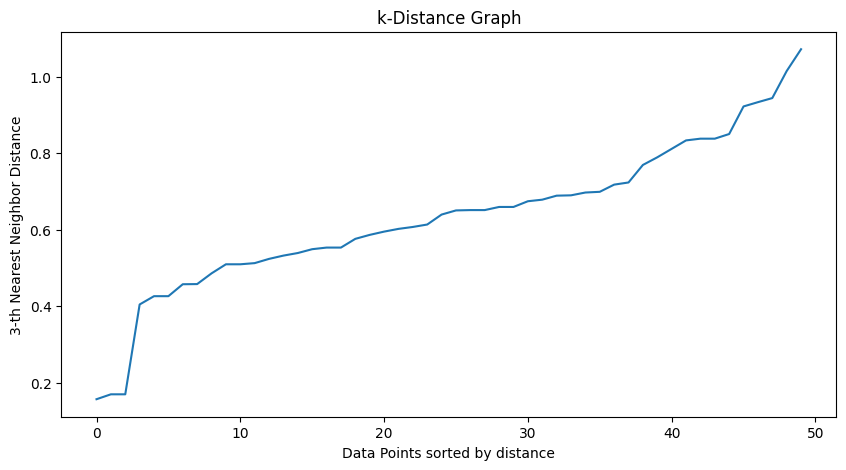

The x-coordinate with the highest derivative is: 1
The corresponding eps value is: 0.1702134907245636


In [6]:

k = 3 # Typically, k is set to min_samples
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(features)
distances, indices = neighbors.kneighbors(features)

# Sort the distances to the k-th nearest neighbor
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('k-Distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.show()

# Compute the second derivative of the distances
derivatives = np.diff(np.diff(distances))

# Find the index of the maximum derivative
max_derivative_index = np.argmax(derivatives)
print(f"The x-coordinate with the highest derivative is: {max_derivative_index}")
print(f"The corresponding eps value is: {distances[max_derivative_index]}")

We can then run the algorithm on a range of values around it in order to find the parameters that give the optimal clusters (typically a high enough number of clusters with as little noise as possible).

eps: 0.3449367582798004, Estimated number of clusters: 3, Number of noise points: 16
eps: 0.35207338086489975, Estimated number of clusters: 3, Number of noise points: 16
eps: 0.35921000344999904, Estimated number of clusters: 3, Number of noise points: 16
eps: 0.3663466260350984, Estimated number of clusters: 2, Number of noise points: 16
eps: 0.37348324862019766, Estimated number of clusters: 1, Number of noise points: 16
eps: 0.380619871205297, Estimated number of clusters: 1, Number of noise points: 16
eps: 0.38775649379039634, Estimated number of clusters: 1, Number of noise points: 16
eps: 0.3948931163754956, Estimated number of clusters: 1, Number of noise points: 14
eps: 0.40202973896059496, Estimated number of clusters: 1, Number of noise points: 14
eps: 0.4091663615456943, Estimated number of clusters: 1, Number of noise points: 14
eps: 0.4163029841307936, Estimated number of clusters: 1, Number of noise points: 14
eps: 0.4234396067158929, Estimated number of clusters: 1, Num

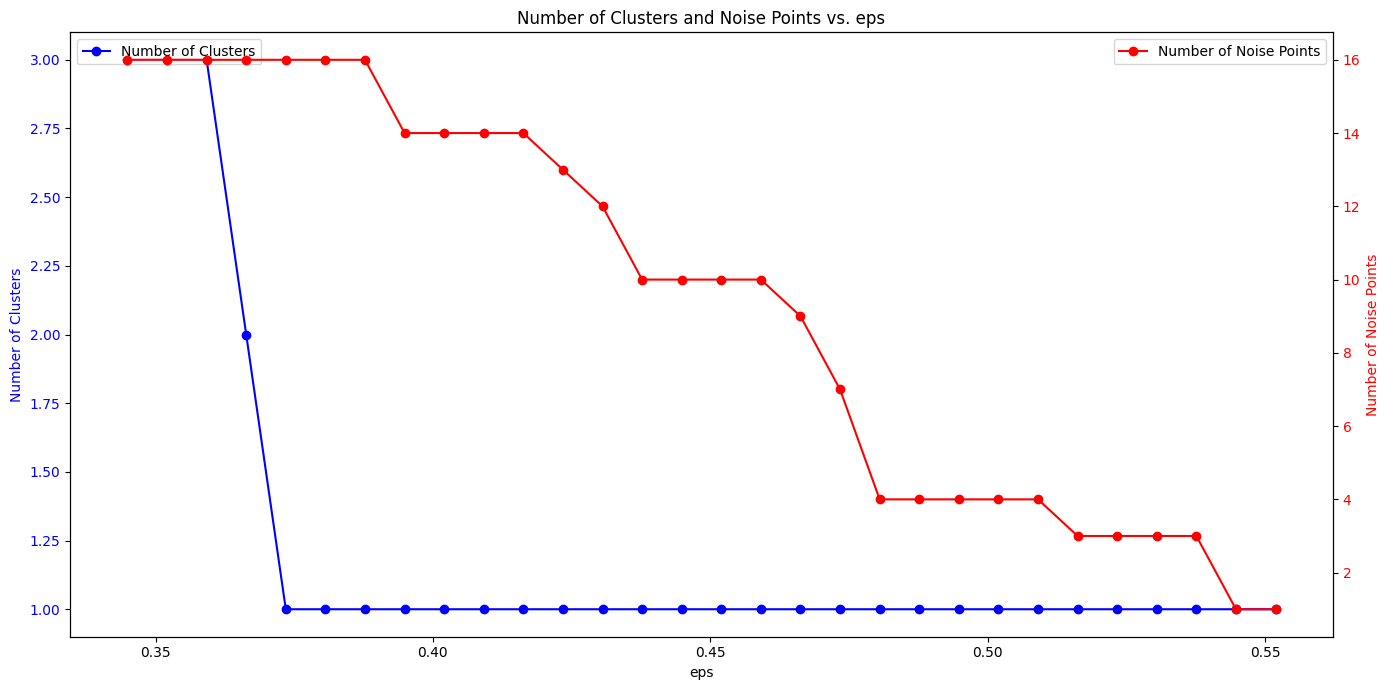

In [42]:

# Range of eps values
eps_min = distances[max_derivative_index] * 0.5
eps_max = distances[max_derivative_index] * 0.8
eps_values = np.linspace(eps_min, eps_max, num=30)

# Lists to store the number of clusters and noise points
num_clusters = []
num_noise_points = []

# Apply DBSCAN with different eps values
for eps_value in eps_values:
    dbscan = DBSCAN(eps=eps_value, min_samples=k)
    cluster_labels = dbscan.fit_predict(features)

    # Analyze the result
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)  # Number of clusters, ignoring noise
    n_noise = list(cluster_labels).count(-1)  # Number of noise points
    num_clusters.append(n_clusters)
    num_noise_points.append(n_noise)
    print(f"eps: {eps_value}, Estimated number of clusters: {n_clusters}, Number of noise points: {n_noise}")

plt.figure(figsize=(14, 7))

# Create the first y-axis
ax1 = plt.gca()
ax1.plot(eps_values, num_clusters, marker='o', label='Number of Clusters', color='b')
ax1.set_xlabel('eps')
ax1.set_ylabel('Number of Clusters', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create the second y-axis
ax2 = ax1.twinx()
ax2.plot(eps_values, num_noise_points, marker='o', label='Number of Noise Points', color='r')
ax2.set_ylabel('Number of Noise Points', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add titles and labels
plt.title('Number of Clusters and Noise Points vs. eps')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

We can then run DBSCAN with these values and compare the clustering to the predictions made

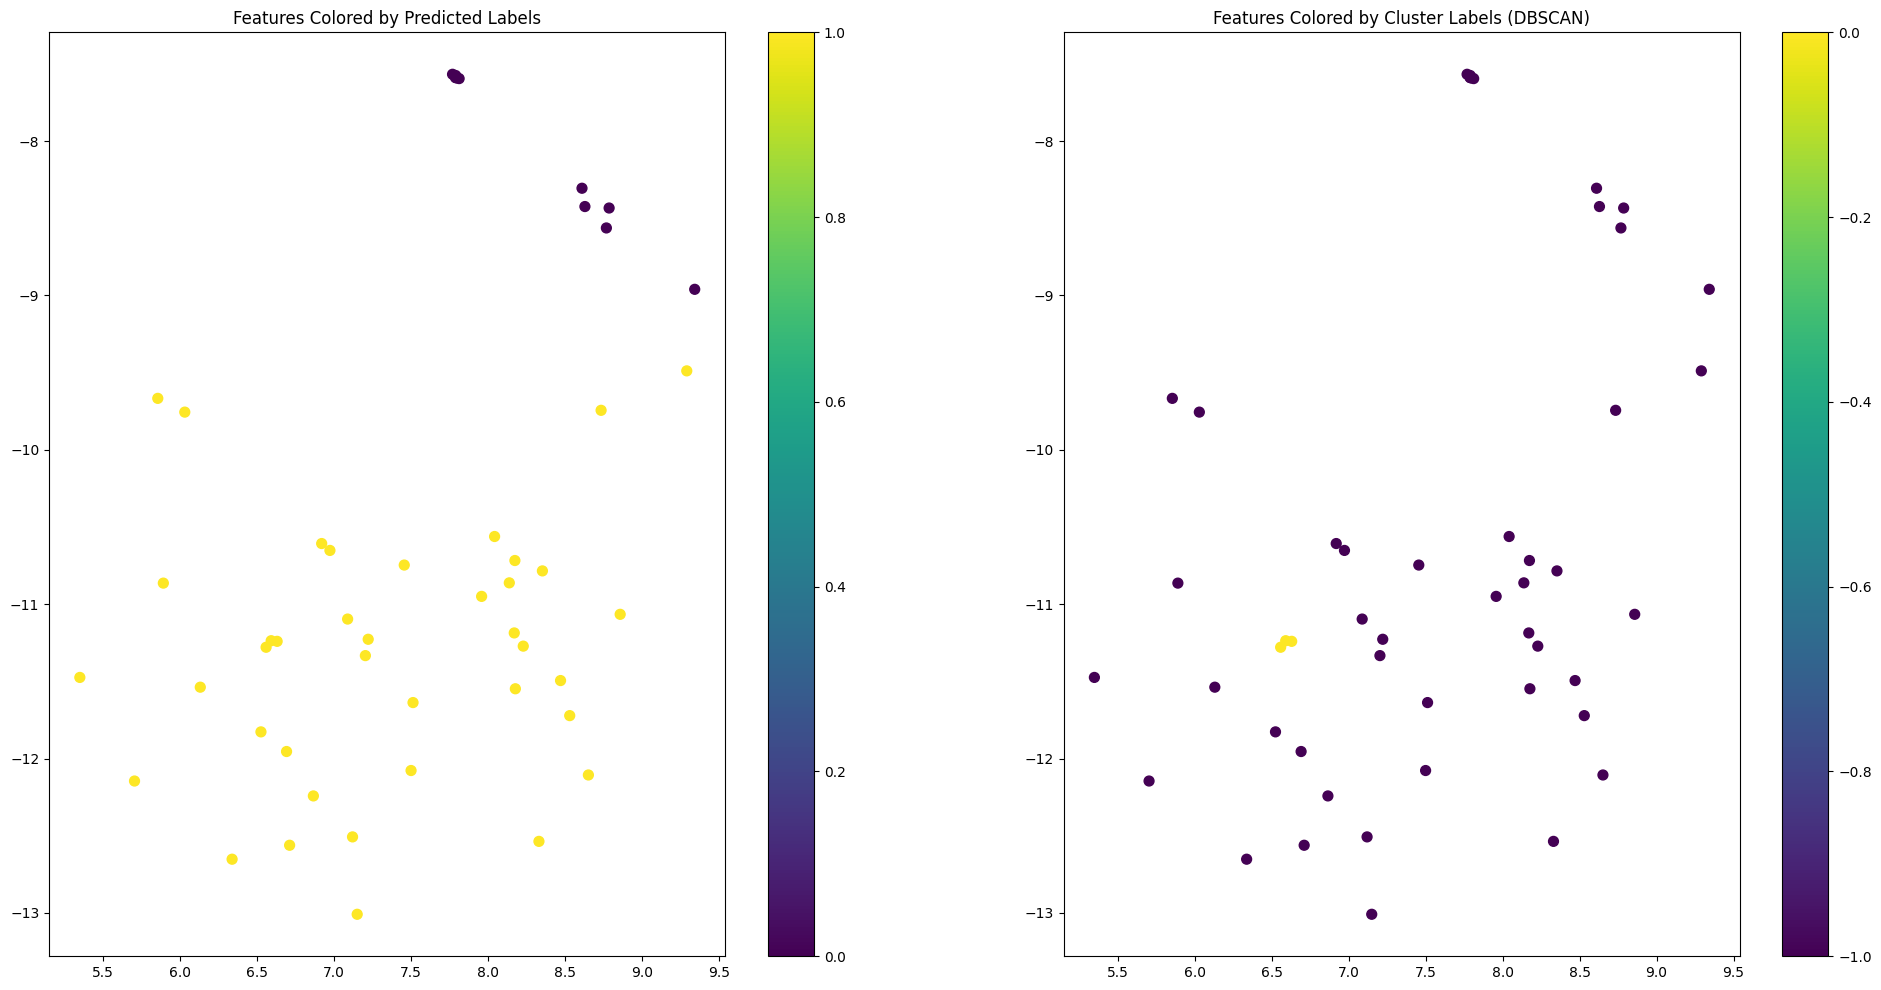

In [7]:
# Apply DBSCAN to cluster features
dbscan = DBSCAN(eps=0.35341701507568357, min_samples=k)
cluster_labels = dbscan.fit_predict(features)

# ===== Plotting =====
# Reduce features to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot 1: Features colored by predicted labels
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=pseudo_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title("Features Colored by Predicted Labels")

# Plot 2: Features colored by cluster labels from DBSCAN
# plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title("Features Colored by Cluster Labels (DBSCAN)")

plt.show()

We can then select a subset of representative examples from the cluster

In [5]:

# Filter out noise points (-1 labels)
unique_labels = set(cluster_labels) - {-1}  # Remove the noise label

# Number of clusters (excluding noise)
num_clusters = len(unique_labels)

# Total points you want to sample
n = 10  # Example, change this to the desired number of samples

# Points per cluster (ensure at least 1 point from each cluster)
points_per_cluster = max(1, n // num_clusters)

# Dictionary to store sampled points
sampled_points = []

# For each cluster, calculate centroid and select closest points
for label in unique_labels:
    # Get points belonging to the current cluster
    cluster_points = features[cluster_labels == label]
    
    # Compute the centroid of the cluster
    centroid = cluster_points.mean(axis=0)
    
    # Compute distances of all points in the cluster to the centroid
    distances = pairwise_distances(cluster_points, centroid.reshape(1, -1))
    
    # Sort points by distance to centroid
    closest_indices = np.argsort(distances.flatten())  # Sort by increasing distance
    
    # Select the closest `points_per_cluster` points
    sampled_cluster_points = cluster_points[closest_indices[:points_per_cluster]]
    
    # Append these sampled points to the result list
    sampled_points.extend(sampled_cluster_points)

# Convert the result back to numpy array
sampled_points = np.array(sampled_points)


NameError: name 'cluster_labels' is not defined

Reduce dimension using T-SNE and plot them

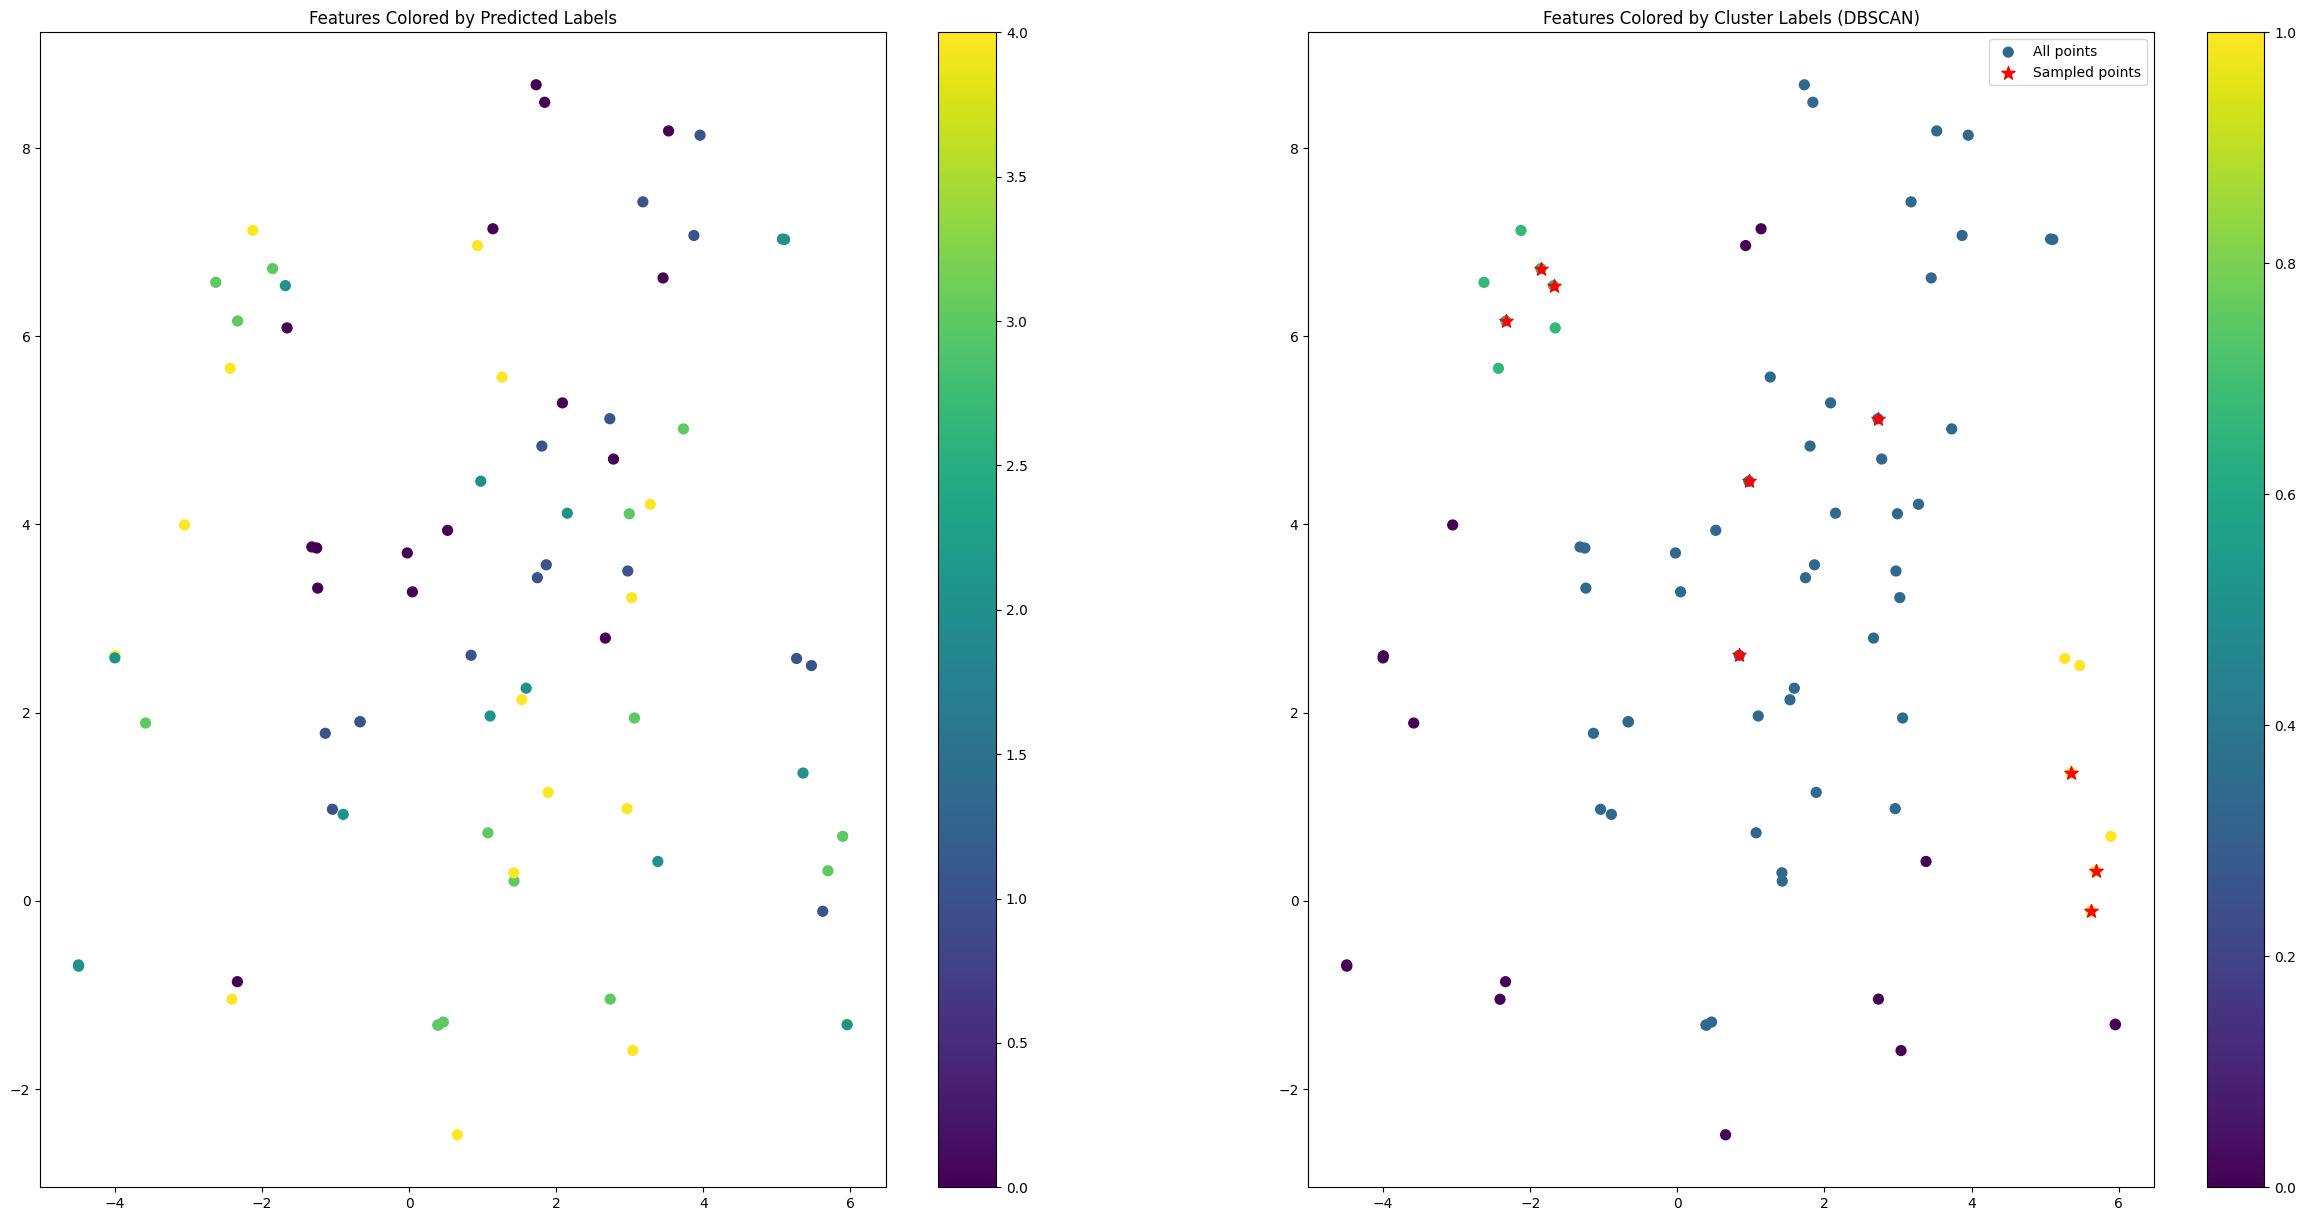

In [45]:
# Perform t-SNE on the entire dataset
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Identify the indices of the sampled points in the original features
sampled_indices = np.array([np.where((features == point).all(axis=1))[0][0] for point in sampled_points])

# Extract the 2D coordinates for the sampled points
sampled_points_2d = features_2d[sampled_indices]

# Plot 1: Features colored by predicted labels (assuming `labels` are defined earlier)
plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=pseudo_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title("Features Colored by Predicted Labels")

# Plot 2: Features colored by cluster labels from DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap='viridis', s=50, label='All points')

# Highlight the sampled points in a different color or marker (e.g., red stars)
plt.scatter(sampled_points_2d[:, 0], sampled_points_2d[:, 1], c='red', marker='*', s=100, label='Sampled points')

plt.colorbar()
plt.title("Features Colored by Cluster Labels (DBSCAN)")

# Add a legend to highlight the sampled points
plt.legend()

plt.show()

Get the corresponding image paths and display them

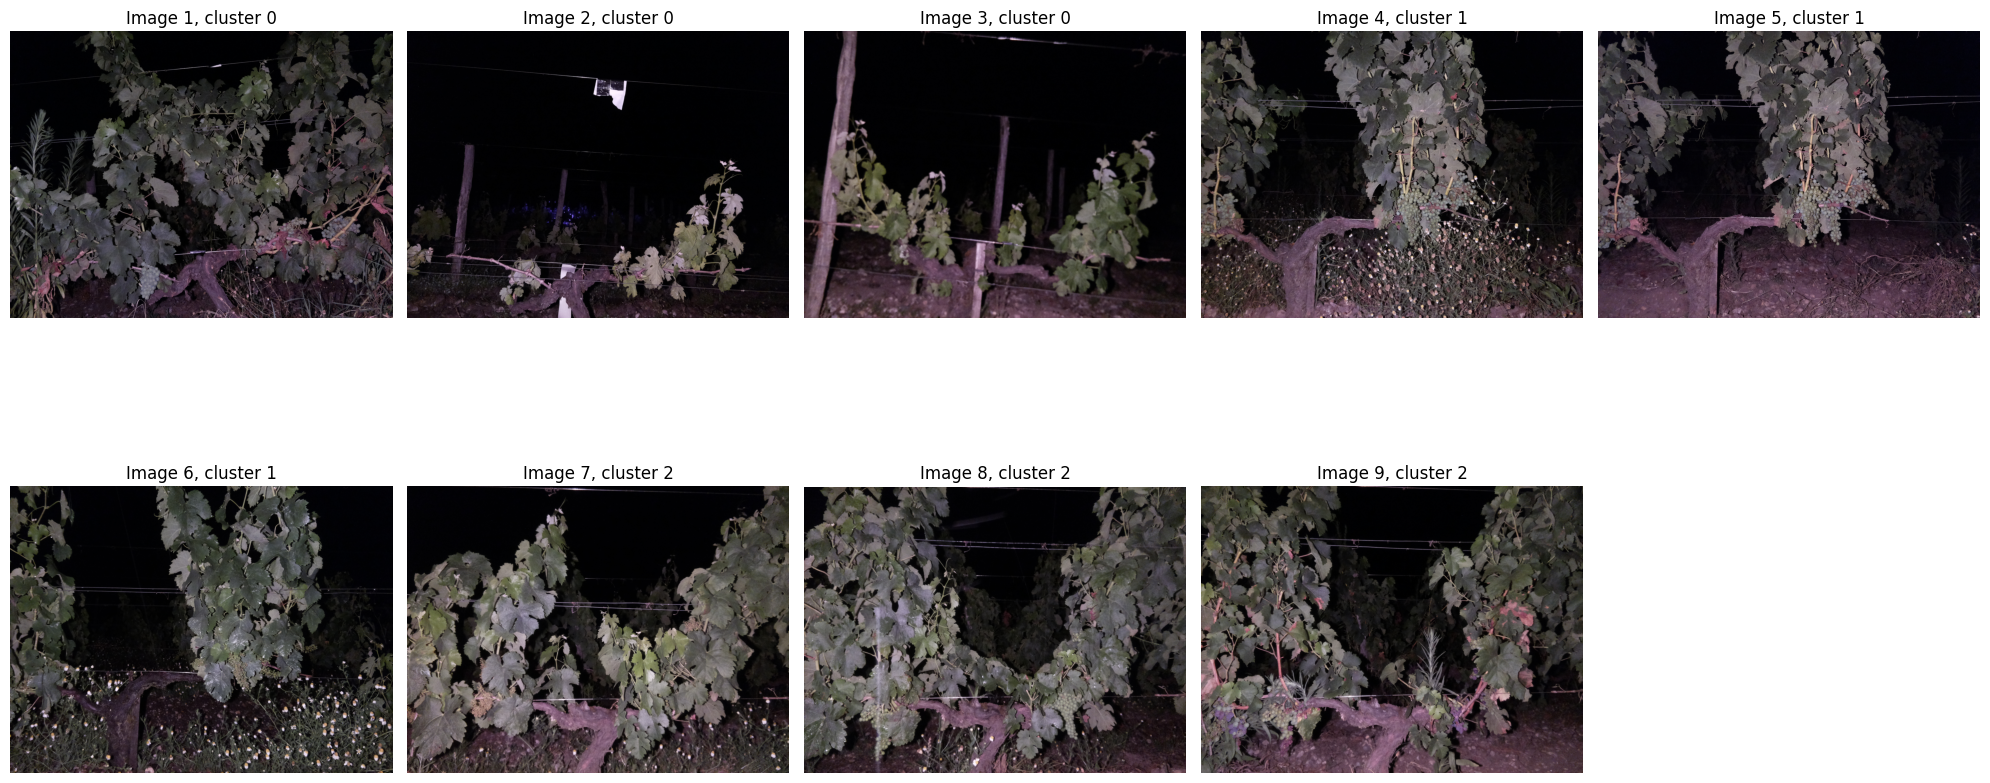

In [46]:
# Find the indices of the sampled points in the original features array
sampled_indices = []
for point in sampled_points:
    # Find the index of the sampled point in the original features array
    index = np.where(np.all(features == point, axis=1))[0][0]
    sampled_indices.append(index)

# Now use the sampled_indices to get the corresponding image file paths
sampled_images = [img_list[idx] for idx in sampled_indices]

# Determine the number of rows and columns for the grid
num_images = len(sampled_images)
num_cols = 5  # Number of columns
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Display the images in a grid layout
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(sampled_images):
    try:
        img = Image.open(img_path)
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}, cluster {cluster_labels[sampled_indices[i]]}")
        plt.axis('off')
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.show()

And save the selected samples to a new directory

In [51]:
# Print the list of sampled images (file paths)
print("Sampled image file paths:")
for img in sampled_images:
    print(img)

# Save the sampled images to a new directory
output_subdir = os.path.join(output_dir, 'DBSCAN')

if not os.path.exists(output_subdir):
    os.makedirs(output_subdir, exist_ok=True)
    
for img in sampled_images:
    img_name = os.path.basename(img)
    output_path = os.path.join(output_subdir, img_name)
    shutil.copy(img, output_path)


Sampled image file paths:
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024\v05_colo_0801_0202_291.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024\v05_colo_0503_0202_201.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024\v08_colo_0511_0202_209.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024\v12_colo_0724_0202_242.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024\v12_colo_0730_0202_248.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024\v12_colo_0621_0202_209.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024\v14_colo_0612_0202_241.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024\v14_colo_0711_0202_270.jpg
C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024\v14_colo_0804_0202_294.jpg


### 2. Using KMeans clustering
<a id="select-kmean"></a>

K-Means clustering is another method of clustering that creates circular clusters, it is more sensitive to outliers but work very well with round clusters.

Lets start by computing the K-Means clusters : you have to set the number of clusters manually 

In [8]:
n_clusters= 3
features_df = pd.DataFrame(features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters, random_state=0).fit(features_df)

# Ensure the number of rows match
if features_df.shape[0] == len(kmeans.labels_):
    features_df['cluster'] = kmeans.labels_
else:
    print("Mismatch in the number of rows between features and kmeans.labels_")

Sample the centroids of the clusters

In [9]:
# Total points you want to sample
n = 10  # Example, change this to the desired number of samples

# Points per cluster (ensure at least 1 point from each cluster)
points_per_cluster = max(1, n // n_clusters)

unique_labels = set(features_df['cluster'])

# Dictionary to store sampled points
sampled_points = []

# For each cluster, calculate centroid and select closest points
for label in unique_labels:
    # Get points belonging to the current cluster
    cluster_points = features_df[features_df['cluster'] == label].drop(columns=['cluster']).values
    
    # Compute the centroid of the cluster
    centroid = cluster_points.mean(axis=0)
    
    # Compute distances of all points in the cluster to the centroid
    distances = pairwise_distances(cluster_points, centroid.reshape(1, -1))
    
    # Sort points by distance to centroid
    closest_indices = np.argsort(distances.flatten())  # Sort by increasing distance
    
    # Select the closest `points_per_cluster` points
    sampled_cluster_points = cluster_points[closest_indices[:points_per_cluster]]
    
    # Append these sampled points to the result list
    sampled_points.extend(sampled_cluster_points)

# Convert the result back to numpy array
sampled_points = np.array(sampled_points)

Reduce dimensions and plot them.<br/>
*(Because of the dimensionality reduction, the centroids may not visually be in the center of mass of the clusters)*

C:\Users\Alexandre Bonin\AppData\Local\Temp\ipykernel_22928\1394520279.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(features_2d[:, 0], features_2d[:, 1], cmap='viridis', s=50, label='All points')


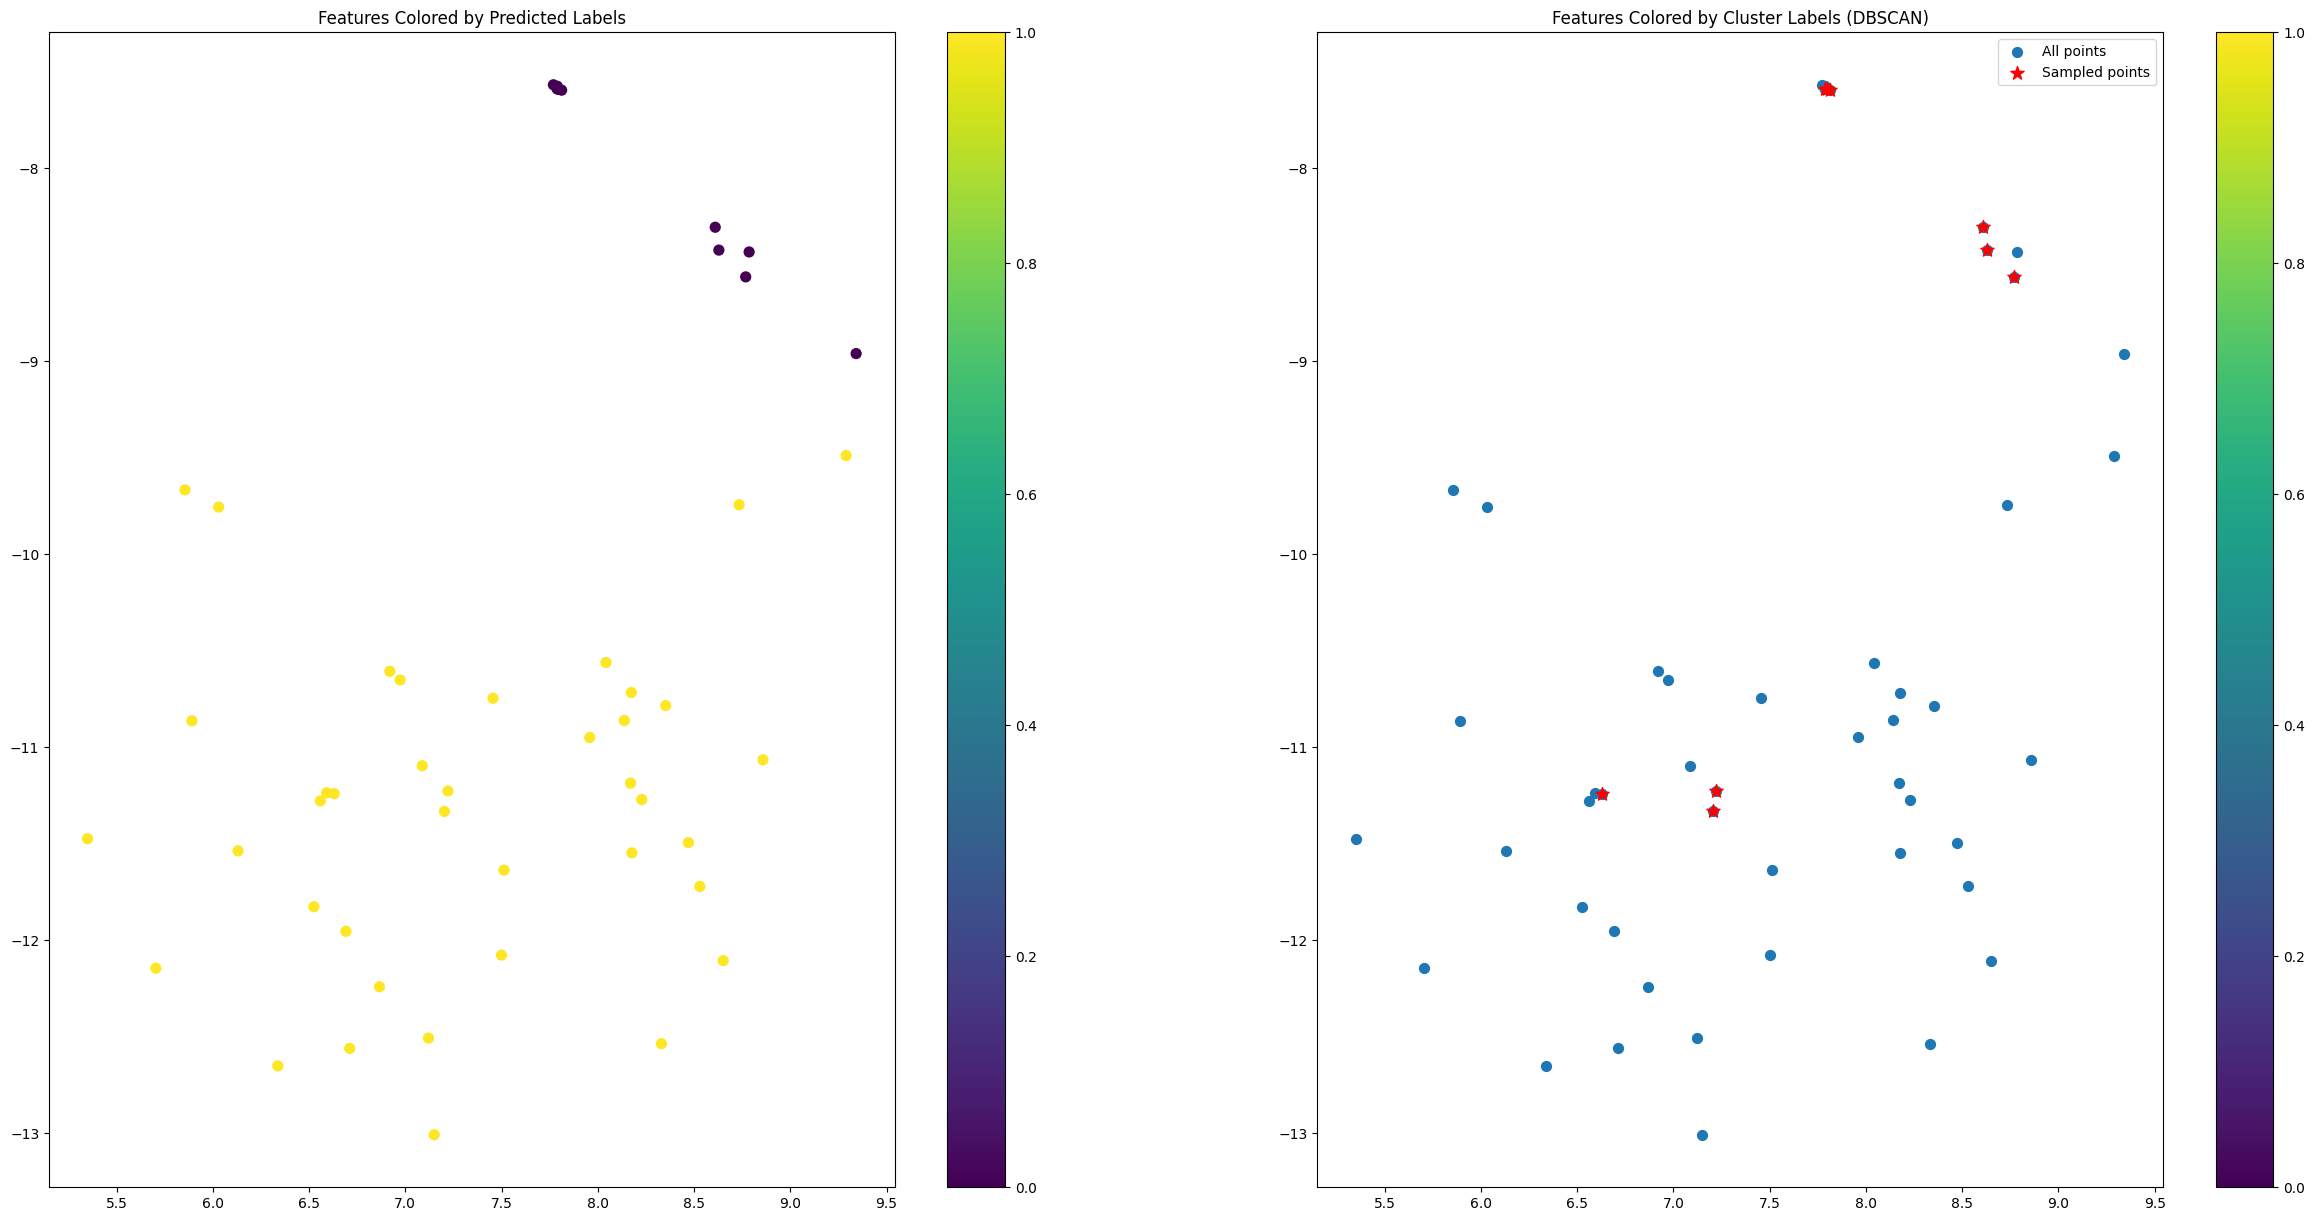

In [11]:
# Perform t-SNE on the entire dataset
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Identify the indices of the sampled points in the original features
sampled_indices = np.array([np.where((features == point).all(axis=1))[0][0] for point in sampled_points])

# Extract the 2D coordinates for the sampled points
sampled_points_2d = features_2d[sampled_indices]
# Plot 1: Features colored by predicted labels
plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=pseudo_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title("Features Colored by Predicted Labels")

# Plot 2: Features colored by cluster labels from DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(features_2d[:, 0], features_2d[:, 1], cmap='viridis', s=50, label='All points')

# Highlight the sampled points in a different color or marker (e.g., red stars)
plt.scatter(sampled_points_2d[:, 0], sampled_points_2d[:, 1], c='red', marker='*', s=100, label='Sampled points')

plt.colorbar()
plt.title("Features Colored by Cluster Labels (DBSCAN)")

# Add a legend to highlight the sampled points
plt.legend()

plt.show()

Get image paths and display them

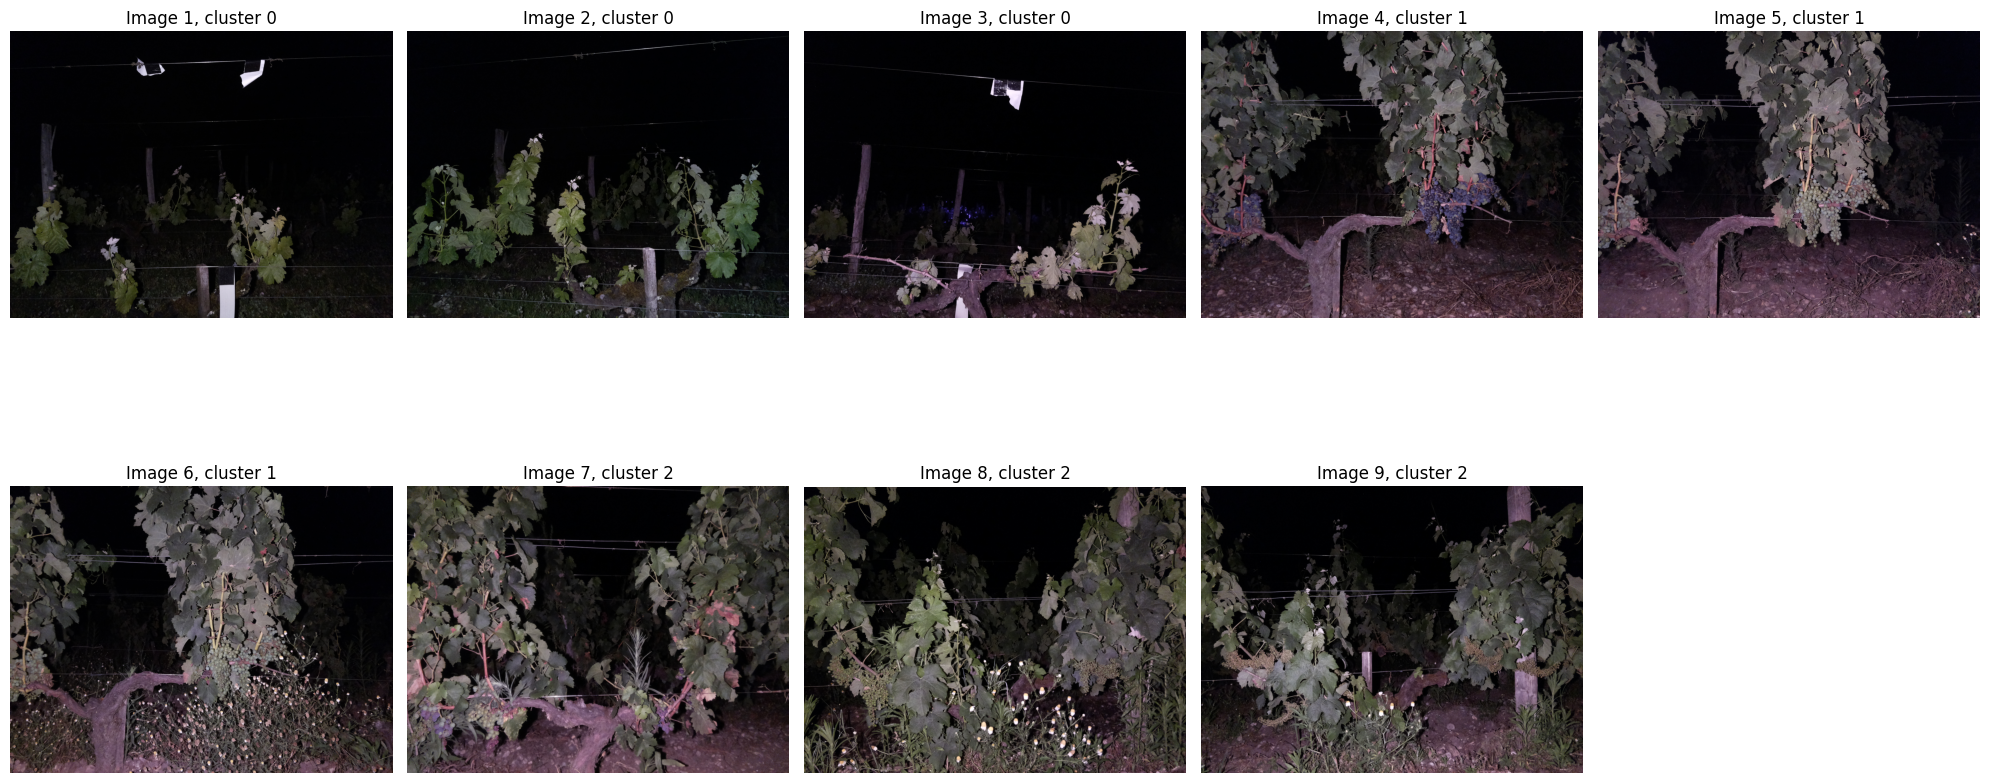

In [77]:
# Find the indices of the sampled points in the original features array
sampled_indices = []
for point in sampled_points:
    # Find the index of the sampled point in the original features array
    index = np.where(np.all(features == point, axis=1))[0][0]
    sampled_indices.append(index)

# Now use the sampled_indices to get the corresponding image file paths
sampled_images = [img_list[idx] for idx in sampled_indices]

# Determine the number of rows and columns for the grid
num_images = len(sampled_images)
num_cols = 5  # Number of columns
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Display the images in a grid layout
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(sampled_images):
    try:
        img = Image.open(img_path)
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}, cluster {features_df['cluster'][sampled_indices[i]]}")
        plt.axis('off')
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.show()

In [17]:
# Print the list of sampled images (file paths)
print("Sampled image file paths:")
for img in sampled_images:
    print(img)

# Save the sampled images to a new directory
output_subdir = os.path.join(output_dir, 'k-means')
if not os.path.exists(output_subdir):
    os.makedirs(output_subdir, exist_ok=True)
    
for img in sampled_images:
    img_name = os.path.basename(img)
    output_path = os.path.join(output_subdir, img_name)
    shutil.copy(img, output_path)

Sampled image file paths:
datasets/test/Camera2_p0928_0930_im_01291.jpg
datasets/test/Reparsac-machine-20211007_p1007_0924_im_10851.jpg
datasets/test/Reparsac-machine-20211007_p1007_0924_im_14752.jpg
datasets/test/camB_p1012_1019_im_00482.jpg
datasets/test/CameraA_p0901_1551_im_00551.jpg
datasets/test/Rions-machine-20211008_p1008_1243_im_01660.jpg
datasets/test/CameraB_p0928_0933_im_03224.jpg
datasets/test/Reparsac-machine-20211007_p1007_0825_p1007_0825_im_02543.jpg


### 3. With K-centers Greedy Algorithm

Based on the following paper : https://arxiv.org/pdf/1708.00489.pdf

This algorithm tries to minimize the distance of all the points to the selected subset



In [33]:

def k_greed(dataset, percentage: float):
    s = [dataset[0]]
    remain_data = [x for x in dataset[1:]]
    d_func = lambda x, y: ((x - y) ** 2).sum()
    indicator = tqdm()
    with indicator:
        while True:
            max_index = None
            max_distance = 0
            for i, data in enumerate(remain_data):
                distance = min([d_func(data, _s) for _s in s])
                if distance > max_distance:
                    max_distance = distance
                    max_index = i
            s.append(remain_data[max_index])
            del remain_data[i]
            indicator.update()
            if float(len(s) / len(dataset)) > percentage:
                return np.stack(s, axis=0)

dataset = features
num_samples = 15
sampled_points = k_greed(dataset, num_samples / len(dataset))

15it [00:00, 352.39it/s]


C:\Users\Alexandre Bonin\AppData\Local\Temp\ipykernel_16988\323841495.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(features_2d[:, 0], features_2d[:, 1], cmap='viridis', s=50, label='All points')


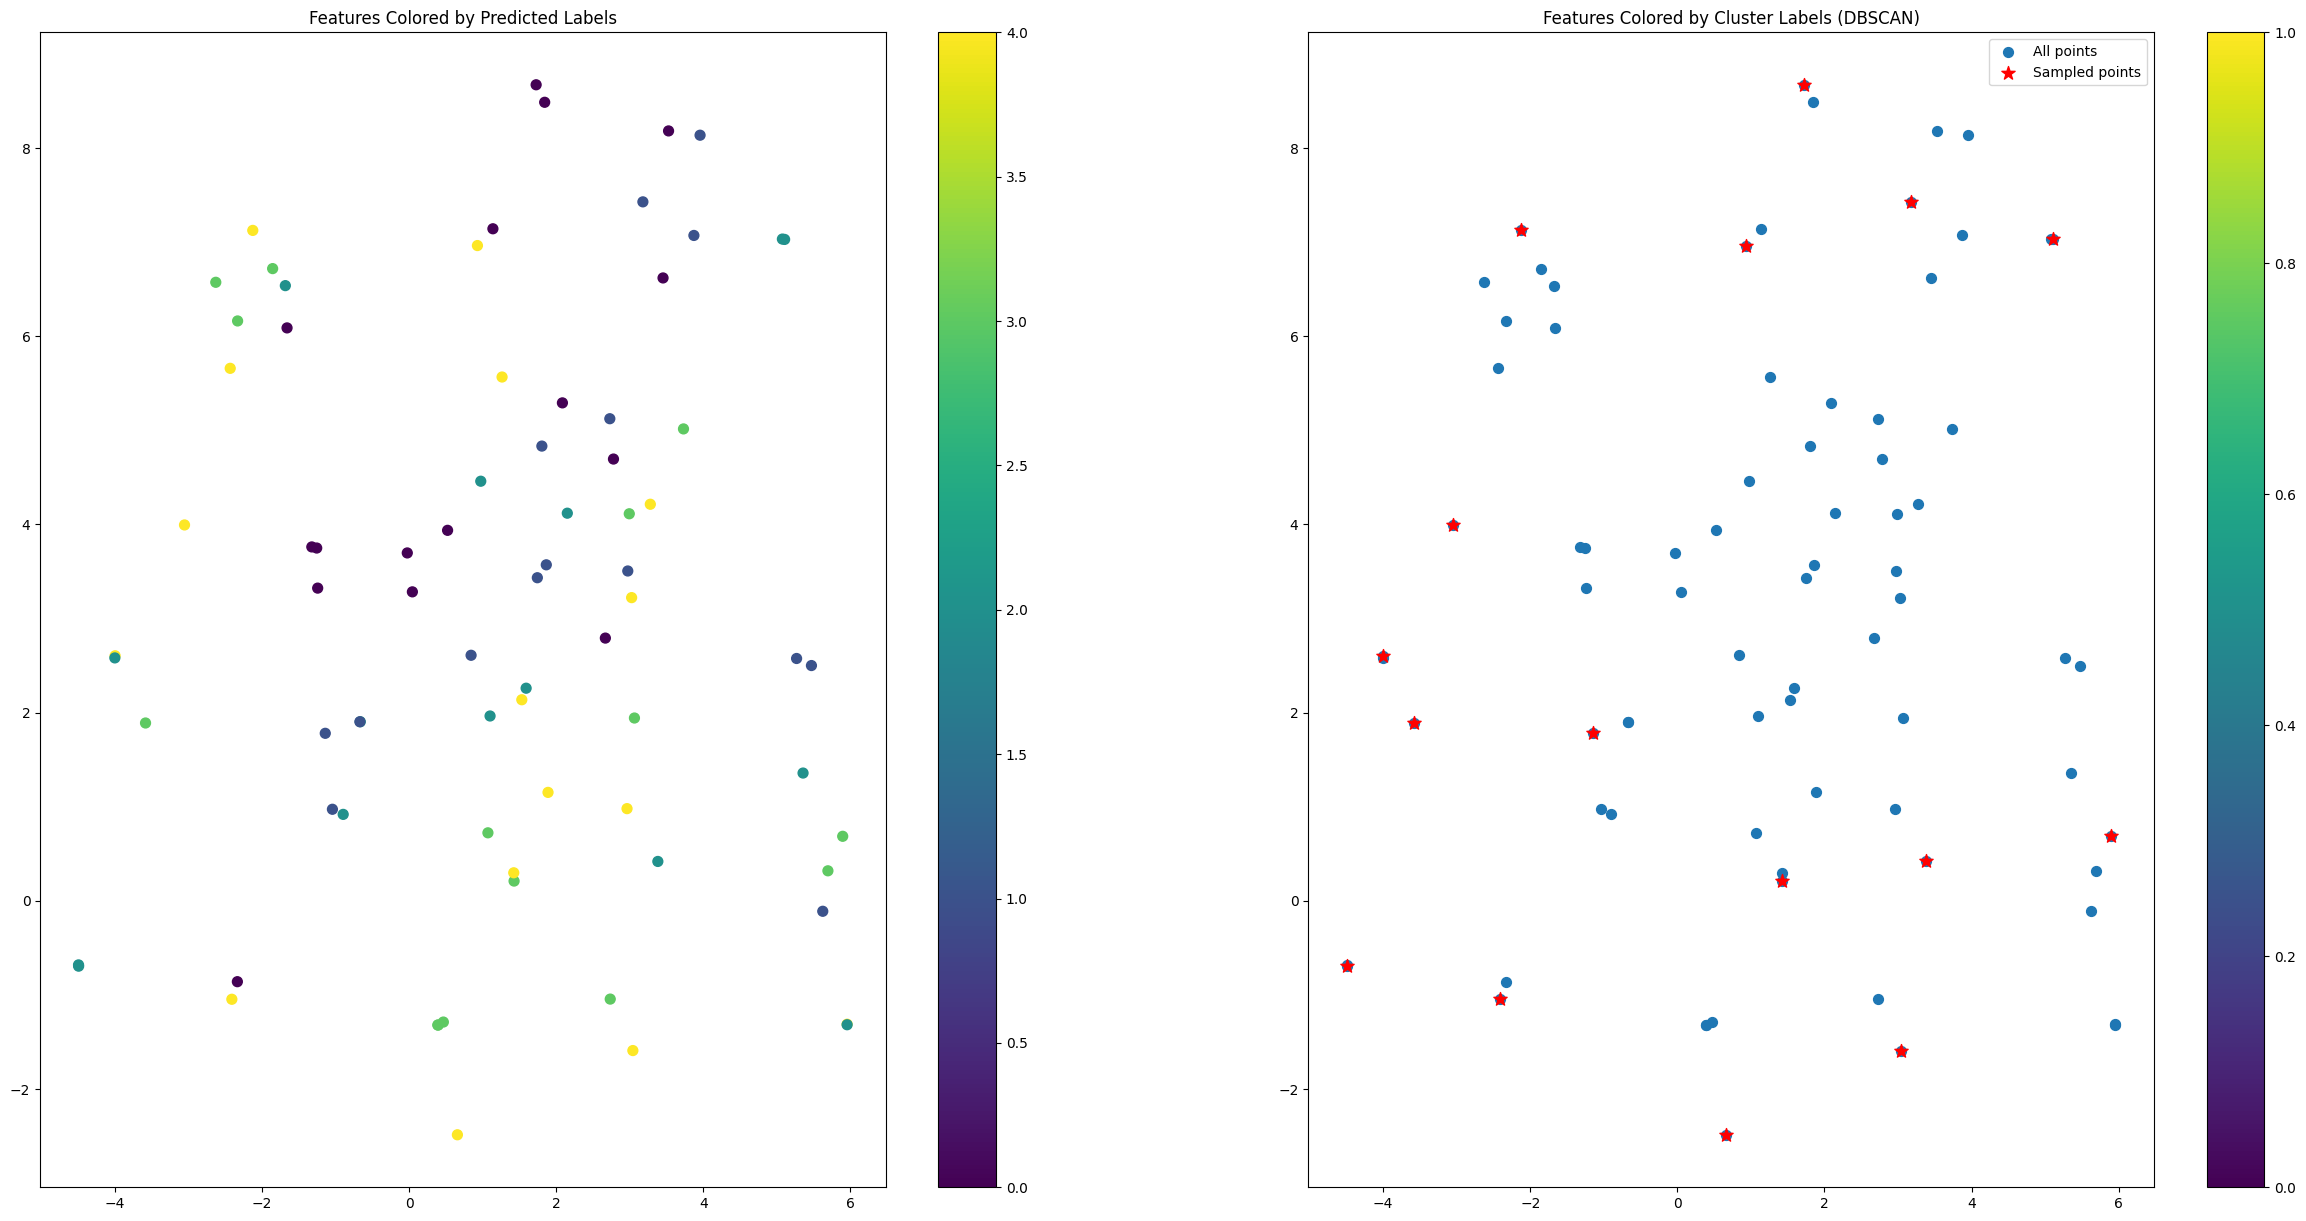

In [34]:
# Perform t-SNE on the entire dataset
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Identify the indices of the sampled points in the original features
sampled_indices = np.array([np.where((features == point).all(axis=1))[0][0] for point in sampled_points])

# Extract the 2D coordinates for the sampled points
sampled_points_2d = features_2d[sampled_indices]
# Plot 1: Features colored by predicted labels
plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=pseudo_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title("Features Colored by Predicted Labels")

# Plot 2: Features colored by cluster labels from DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(features_2d[:, 0], features_2d[:, 1], cmap='viridis', s=50, label='All points')

# Highlight the sampled points in a different color or marker (e.g., red stars)
plt.scatter(sampled_points_2d[:, 0], sampled_points_2d[:, 1], c='red', marker='*', s=100, label='Sampled points')

plt.colorbar()
plt.title("Features Colored by Cluster Labels (DBSCAN)")

# Add a legend to highlight the sampled points
plt.legend()

plt.show()

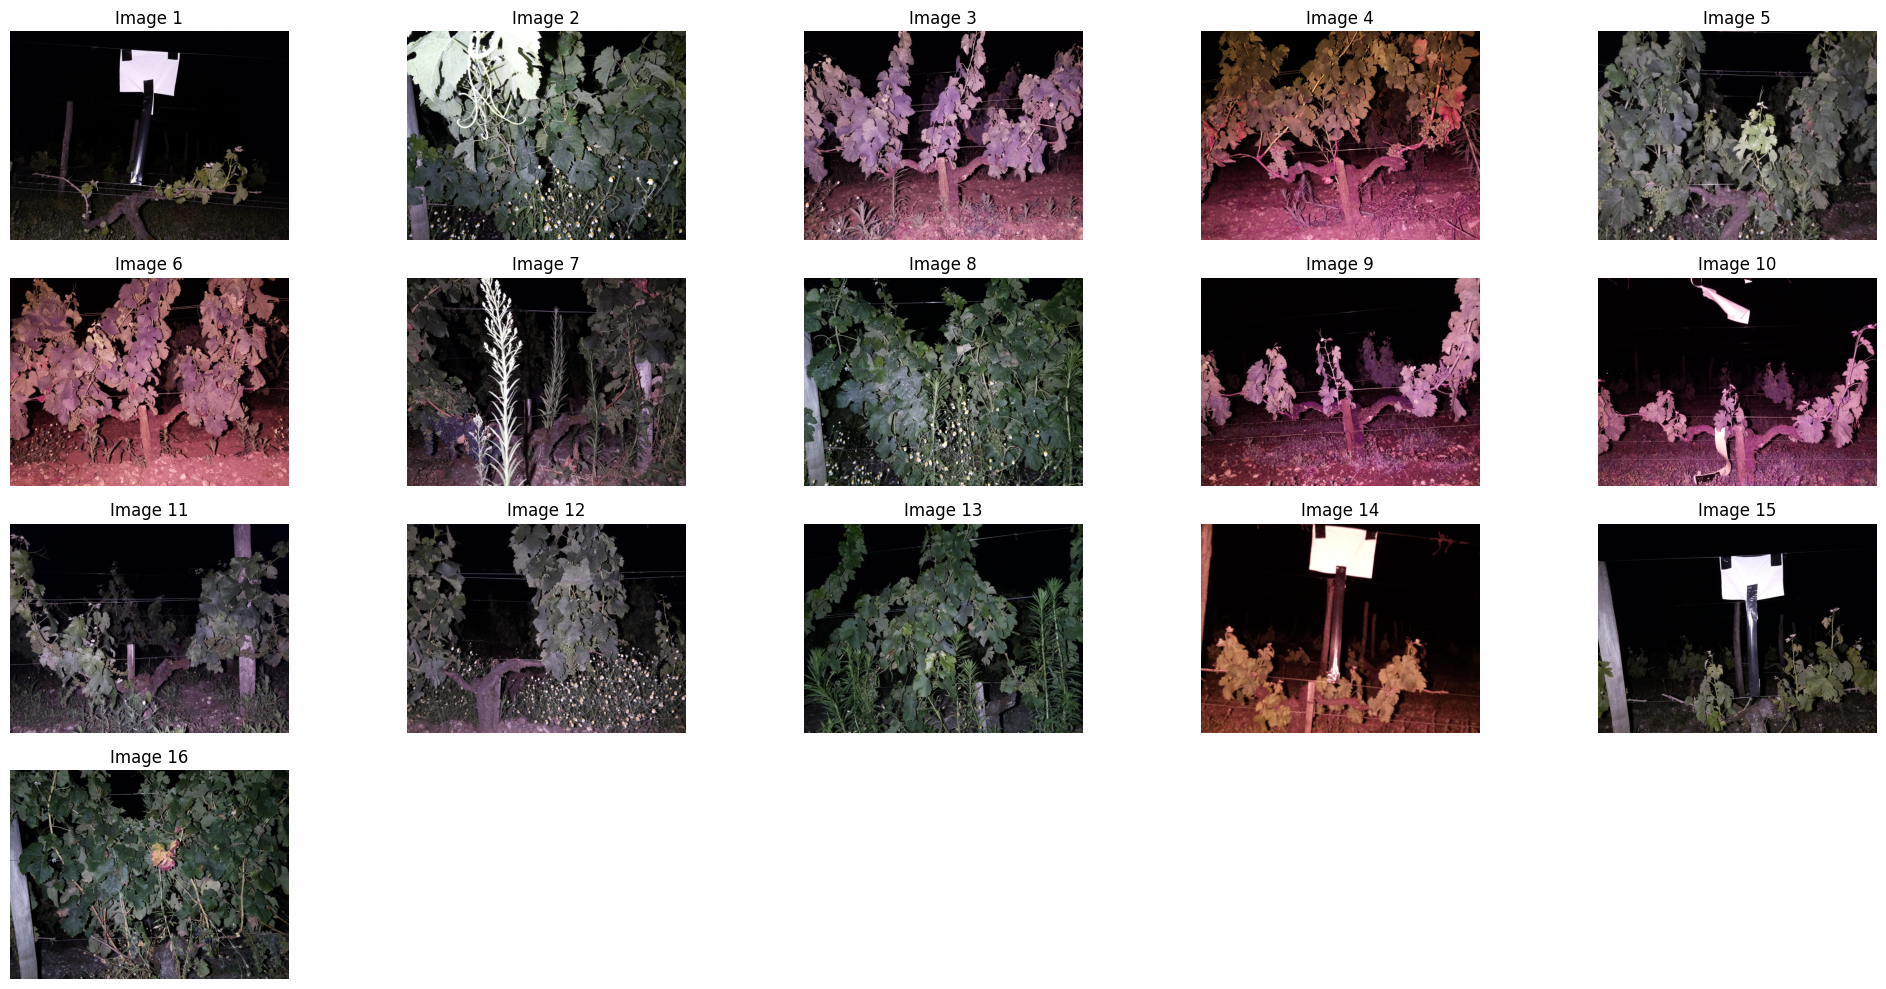

In [35]:
# Find the indices of the sampled points in the original features array
sampled_indices = []
for point in sampled_points:
    # Find the index of the sampled point in the original features array
    index = np.where(np.all(features == point, axis=1))[0][0]
    sampled_indices.append(index)

# Now use the sampled_indices to get the corresponding image file paths
sampled_images = [img_list[idx] for idx in sampled_indices]

# Determine the number of rows and columns for the grid
num_images = len(sampled_images)
num_cols = 5  # Number of columns
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Display the images in a grid layout
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(sampled_images):
    try:
        img = Image.open(img_path)
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.show()

In [ ]:
# Print the list of sampled images (file paths)
print("Sampled image file paths:")
for img in sampled_images:
    print(img)

output_subdir = os.path.join(output_dir, 'k-centers')

if not os.path.exists(output_subdir):
    os.makedirs(output_subdir, exist_ok=True)
    
for img in sampled_images:
    img_name = os.path.basename(img)
    output_path = os.path.join(output_subdir, img_name)
    shutil.copy(img, output_path)

## Uncertainty Sampling with confidence score
<a id="u-sampling"></a>

After labeling a good number of core-set image, it is advised to switch to marginal cases handling. This is done by using Uncertainty sampling : selecting images on which the model is the most uncertain.

In [4]:
# Calculate the highest probability for each image
if mode == 'segmentation':
    pred_df['max_prob'] = pred_df['pred']
elif mode == 'classification':
    pred_df['max_prob'] = pred_df['pred'].apply(max)

# Sort the DataFrame by the highest probability in ascending order
pred_probas_sorted = pred_df.sort_values(by='max_prob')

# Select the top n images with the lowest highest probability
n = 15
sampled_images = pred_probas_sorted.head(n)

# Determine the number of rows and columns for the grid
num_images = len(sampled_images)
num_cols = 5  # You can adjust this value as needed
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Display the images in a grid layout
plt.figure(figsize=(20, 10))
for i in range(num_images):
    try:
        img_path = sampled_images.iloc[i]['file_path']
        img = Image.open(img_path)
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}, Confidence : {sampled_images.iloc[i]['max_prob']:.2f}")
        plt.axis('off')
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [29]:
# Save the sampled images to a new directory
output_subdir = os.path.join(output_dir, 'uncertainty')
if not os.path.exists(output_subdir):
    os.makedirs(output_subdir, exist_ok=True)
    
for img in sampled_images:
    img_name = os.path.basename(img)
    output_path = os.path.join(output_subdir, img_name)
    shutil.copy(img, output_path)